# Self Test 2
## 2.1 - Fitting a self organizing map to in-game data

In [4]:
import numpy as np
import networkx as nx
import numpy.random as rnd
import string
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

def tnc(data):
    """ To Normal Coordinates"""
    if len(data.shape) > 1:
        data = data[:,1],data[:,0],data[:,2]
    else:
        data = data[1],data[0],data[2]
    return data

def plot(data):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(*tnc(data), marker='o')
    plt.show()

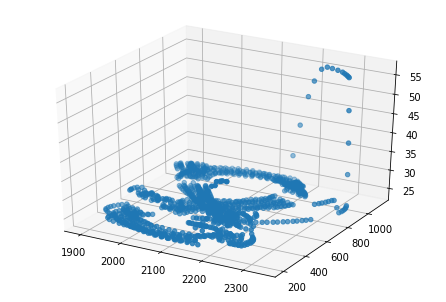

In [5]:
matX = np.genfromtxt('../data/q3dm1-path2.csv',delimiter=',')
plot(matX)

In [10]:
def initRingSOM(matX, neurons, start=1):
    G = nx.generators.lattice.grid_2d_graph(neurons, start, periodic=True)
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(m, neurons, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[smpl[i],:]
    return G

def initGlasses(matX, neurons=20):
    assert neurons % 2 == 0, "k=%r invalid, the number of neurons can only be even" % k
    half_neurons = neurons // 2
    G1 = initRingSOM(matX, half_neurons)
    G2 = initRingSOM(matX, half_neurons)
    G = nx.disjoint_union(G1,G2)
    G.add_edge(half_neurons-1, half_neurons)
    return G

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    #
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, m, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a row of matrix X
        vecX = matX[smpl[t],:]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
    return G

In [12]:
G = initGlasses(matX, 24)
SOM1 = trainSOM(matX, G, tmax=10000)

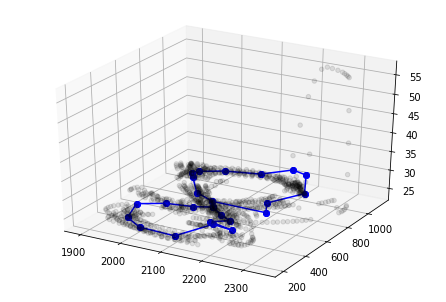

In [15]:
def plot_SOM_on_data(data, graph, SOM_color='red', data_color=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.scatter(*tnc(data), color=data_color, alpha=0.1)
    for u, v in graph.edges():
        dot1 = tnc(graph.nodes[u]['w'])
        dot2 = tnc(graph.nodes[v]['w'])
        edge = np.array([dot1, dot2]).T
        ax.plot(*edge, '-o', color=SOM_color)
    plt.show()

plot_SOM_on_data(matX, SOM1, 'blue', 'black')

In [16]:
def get_dist(x1, x2):
    return np.sum((x1-x2)**2)**0.5

def compute_mse(matX, G):
    dists = []
    for x in matX:
        small_dist = np.inf
        # loop for every node
        for i in range(len(G.nodes())):
            # compute distance
            dist = get_dist(x,G.nodes[i]['w'])
            # save smallest distance
            if dist < small_dist:
                small_dist = dist
            
        dists.append(small_dist)
    dists = np.array(dists)
    mse = sum(dists**2) / len(dists)
    return mse

In [17]:
mse = compute_mse(matX, G)
round(mse, 2)

1692.25

## 2.2 - Action primitives from in-game data

In [18]:
def get_velocities(matX):
    velocities = []

    for i in range(1, matX.shape[0]):
        vel = matX[i] - matX[i-1]
        velocities.append(vel)
    return np.array(velocities)

def compute_avg_vel(velocities):
    return velocities.sum(axis=0) / velocities.shape[0]

In [19]:
vels = get_velocities(matX)
avg = compute_avg_vel(vels)
avg.round(4)

array([-0.338 ,  0.1112,  0.    ])

In [20]:
import scipy.cluster.vq as vq

matA, inds = vq.kmeans2(matX, k=24, iter=100, minit='++')

In [21]:
vels = get_velocities(matA)
avg = compute_avg_vel(vels)
avg.round(4)

array([ 9.3930e-01,  7.3326e+00, -1.0000e-04])